In [3]:
%pylab inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn import metrics, cross_validation
from sklearn.metrics import confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [4]:
# by default, skip header 0 is skipping zero line
# so here we skip the header first line of data is trash
# return a train_matrix with all the data
def read_from_csv(filename):
    train_matrix = np.genfromtxt(filename, delimiter = ',', skip_header = 1)
    train_matrix.shape
    return train_matrix

In [5]:
# this method is spilting the label(first column)
def get_label_arrays(train_matrix):
    labels = train_matrix[ : ,:1]
    return labels
    

In [6]:
# remaining columns are pixels
def get_pixels_arrays(train_matrix):
    pixels = train_matrix[ : ,1:]
    return pixels

In [7]:
# get first 10 example digits
def get_example_digits(train_matrix):
    i = 0
    j = 0
    found = np.zeros(shape = (10, 785))
    while i < 10:
        if i == get_label_arrays(train_matrix)[j]:
            found[i] = train_matrix[j]
            i = i + 1
            j = 0      
        else:
            j = j + 1
    return found

In [8]:
# draw the first 10 digits
def draw_digits(pixels):
    j = 0
    while j < 10:
        image = pixels[j].reshape(28, 28)
        plt.subplot(2, 5, j+1)
        plt.gray()
        plt.imshow(image)
        j = j + 1
    plt.savefig("10digits.png")
        

In [9]:
# plot the historgram and label axis
def print_histogram(labels):
    plt.figure()
    n, bins, patches = plt.hist(labels, 10, normed=True)
    for patch in patches:
        patch.set_height(patch.get_height()/sum(n))
    plt.xlabel("Digit")
    plt.ylabel("Probability")
    plt.title("Histogram of each digits in Kaggle Dataset")
    plt.grid(True)
    plt.savefig("Hist_each_digs.png")

In [10]:
# this method iterates through the entire training data and calculate the distance
# between one digit and other training data. Then save the shortest distance into the neighbor array.
# One thing need to be careful is (distance!=0), this is ensure that do not save the digit itself, which
# will always has a a distance zero

def find_nearest_neighbor(single_digit,train_matrix):
    neighbor = np.zeros(shape = (1,785))
    min_distance = sys.maxsize
    for i in range(len(train_matrix)):
        iterator = train_matrix[i]
        # only calculating metric: 1-785 columns; not counting labels
        distance = la.norm(iterator[1:785] - single_digit[1:785])
        # make sure that is not same pict(distance!=0)
        if distance < min_distance and distance !=0:
                   min_distance = distance
                   neighbor = iterator
    return neighbor

In [11]:
# straighfoward method to draw the images
def draw_nearest_neighbor(example, nearest_neighbor_train_matrix):
    nearest_neighbor_pixels = get_pixels_arrays(nearest_neighbor_train_matrix)
    example_pixels = get_pixels_arrays(example)
    nearest_neighbor_labels = get_label_arrays(nearest_neighbor_train_matrix)
    example_labels = get_label_arrays(example_pixels)
    for i in range(len(example_pixels)):
        image1 = example_pixels[i].reshape(28, 28)
        image2 = nearest_neighbor_pixels[i].reshape(28, 28)
        plt.subplot(10, 2, i * 2 + 1)
        plt.gray()
        plt.imshow(image1)
        plt.subplot(10, 2, i * 2 + 2)
#         if(example_labels[i] != nearest_neighbor_labels[i]):
#             plt.title("**********")
        plt.imshow(image2)        
    plt.savefig("Nearest_neighbor_comparsion.png")
        

In [12]:
# this method iterates through the train_matrix, and by comparing the label of the matrix,
# save the corresponding matrix to zeros, ones
def get_zeros_and_ones(train_matrix):
    labels = get_label_arrays(train_matrix)
    pixels = get_pixels_arrays(train_matrix)
    zeros = []
    ones = []
    for i in range(len(train_matrix)):
        if labels[i] == 0:
            zeros.append(train_matrix[i])
        elif labels[i] == 1:
            ones.append(train_matrix[i])
        else:
            continue
    zeros = np.array(zeros)
    ones = np.array(ones)
    return zeros, ones    


In [13]:
def get_genuine_distance(train_matrix):
    pixel = get_pixels_arrays(train_matrix)
    distance = []
    i = 0
    while i < len(pixel):
        j = i + 1
        while j < len(pixel):
            distance.append(la.norm(pixel[i] - pixel[j]))
            j += 1
        i += 1
    return distance
  
            

In [14]:
 
def get_imposter_distance(zeros, ones):
    zeros_pixel = get_pixels_arrays(zeros)
    ones_pixel = get_pixels_arrays(ones)
    distance = []
    for i in range(len(zeros_pixel)):
        for j in range(len(ones_pixel)):
            distance.append(la.norm(zeros_pixel[i] - ones_pixel[j]))
    return distance
            

In [15]:
def print_genuineAndImposter_histogram(genuine, imposter):
    plt.figure()
    plt.legend()
    plt.hist(genuine, 100, label="Genuine Distances")
    plt.hist(imposter, 100, label="Imposter Distances")
    plt.title("Histogram of Genuine and Imposter Distances")
    plt.show()
    plt.savefig("dsitance_genuine_imposter.png")

In [16]:
# KNN_classifier works for now
def kNN_classifier(k, target, pixels, labels):
    #store all the distance parameters in distances list
    distances = []
    for index in range(len(pixels)):
        distance = la.norm(target - pixels[index])
        distances.append((distance, index))
    # sort distances list in term of distance
    distances.sort(key=lambda elem: elem[0])
    neighbors = []
    # store the first k distances index in neighbors
    for index in range(k):
        neighbors.append(distances[index][1])
    # now iterate the neighbors, to find the most voted label
    count = [0] * 10
    for index in range(len(neighbors)):
        digit_label = int(labels[neighbors[index]])
        count[digit_label]+=1
    
#     print (count)
    for index in range(len(count)):
        if count[index] == max(count):
            return index
    return -20000

In [17]:
# X is the training data(column 1:785), this is pixels
# Y is the label(column 0)
# train_index, test_index is the matrix indices from cross_validation
# this method calls KNN_classifer to calculate each training data's label, then compare to real label to calculate the
# accuracy. Also, confusion_matrix is also established here. Remeber, the diagnoal of confusion matrix is the one
# that matches the result. 
def classify_and_test_accuracy(X, Y, train_index, test_index):
    
    k = 5
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    
    Y_predicted = np.zeros(len(X_test))

           
    for index in range(len(X_test)):
        Y_predicted[index] = kNN_classifier(k, X_test[index], X_train, Y_train)
        # make the confusion matrix, row is real result, column is predicted
        confusion_matrix[int(Y_test[index])][int(Y_predicted[index])] += 1
    
    correct = 0
    for index in range(len(Y_predicted)):
        if(Y_predicted[index] == Y_test[index]):
            correct +=1
    return correct/float(len(Y_test))

In [18]:
def test_kNN_accuracy(X, Y, train_indices, test_indices):
    k = 5
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    Y_predicted = np.zeros(len(Y_test))
    for index in range(len(X_test)):
        Y_predicted[index] = kNN_classifier(k, X_test[index], X_train, Y_train)
        confusion_matrix[int(Y_test[index])][int(Y_predicted[index])] += 1
    return (Y_predicted == Y_test).sum() / float(len(Y_test))


In [21]:
# part a
train_matrix = read_from_csv('train.csv')

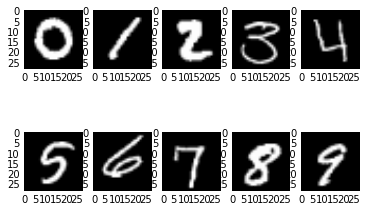

In [22]:
# b
example = get_example_digits(train_matrix)
example_labels = get_label_arrays(example)
example_pixels = get_pixels_arrays(example)
draw_digits(example_pixels)

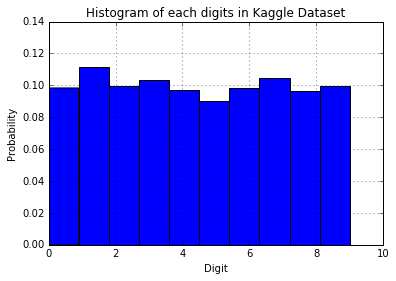

In [23]:
# part c
labels = get_label_arrays(train_matrix)
print_histogram(labels)

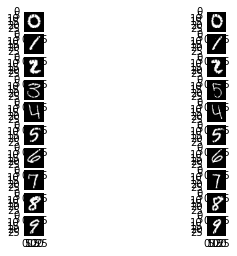

In [26]:
# part D DSB
nearest_neighbor_train_matrix = np.zeros(shape = (10, 785))
for i in range(len(example)):
    nearest_neighbor_train_matrix[i] = find_nearest_neighbor(example[i], train_matrix)
draw_nearest_neighbor(example, nearest_neighbor_train_matrix)
    

In [27]:
# start of part e; imposter contains list of distances
zeros, ones = get_zeros_and_ones(train_matrix) 
imposter_distance = get_imposter_distance(zeros, ones)
print (len(imposter_distance))

19354288


In [28]:
# merge genuine zero distance and one distance together
zero_distance = get_genuine_distance(zeros)
one_distance = get_genuine_distance(ones)


In [29]:
genuine_distance = zero_distance + one_distance
print(len(genuine_distance))

19502232


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


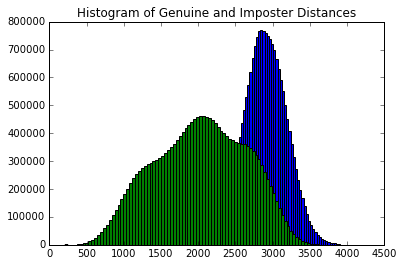

In [30]:
# plot part e 
print_genuineAndImposter_histogram(imposter_distance, genuine_distance)

In [31]:
# f Generate an ROC curve from the above sets of distances.
# What is the equal error rate? What is the error rate of a classifier that simply guesses randomly?

# max possible distance of 784 pixels, but smaller distance means better fit(higher score)
# so I did a trick to convert distance to score
max_distance = 255 * 255 * 784
# re-arrange list to array
genuine_distance = np.array(genuine_distance)
imposter_distance = np.array(imposter_distance)
genuine_score = max_distance - genuine_distance
imposter_score = max_distance - imposter_distance
# make y-true binary labels, binarize output

y_true = np.append(np.zeros(len(imposter_score)), np.ones(len(genuine_score)))
y_true.shape

(38856520,)

In [32]:

y_score = np.append(imposter_score, genuine_score)
y_score.shape

(38856520,)

In [33]:
# cacluate false postitve rate and true postive rate
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)

In [38]:
roc_auc = metrics.auc(fpr, tpr)

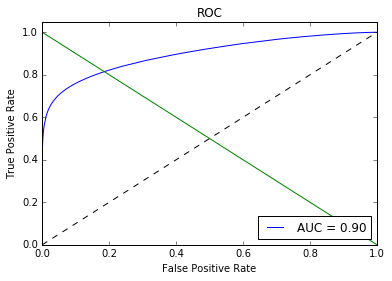

In [39]:
# plot the roc curve
# ref: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.plot([1, 0], [0, 1])
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC")
plt.legend(loc='lower right')
plt.show()
# saving does not work, comment out
# plt.savefig('ROC.jpg')

In [92]:
# g and h
X = train_matrix[:, 1:]
Y = train_matrix[:, 0]
print (X.shape)
print (Y.shape)

(42000, 784)
(42000,)


In [137]:
# test kNN_classifier passed
# print(Y[20123])
# kNN_classifier(3, X[20123],X,Y)
confusion_matrix = np.zeros((10,10))
for train_index, test_index in cross_validation.KFold(len(X), n_folds=3):
    accuracy = classify_and_test_accuracy(X, Y, train_index, test_index)
    print (accuracy)

0.9645714285714285
0.9631428571428572
0.9649285714285715


In [138]:
# calcuate the digit_accuracy by using the confusion matrix and print out
digit_accuracy = []
for i in range(10):
    digit_count = 0
    for j in range(10):
        digit_count += confusion_matrix[i][j]
    digit_accuracy.append(confusion_matrix[i][i]/float(digit_count))
    print ("digit "+str(i)+" accuracy is "+str(digit_accuracy[i]))

digit 0 accuracy is 0.993223620523
digit 1 accuracy is 0.99487617421
digit 2 accuracy is 0.949485276514
digit 3 accuracy is 0.963686508849
digit 4 accuracy is 0.958988212181
digit 5 accuracy is 0.953623188406
digit 6 accuracy is 0.986463620981
digit 7 accuracy is 0.969097932288
digit 8 accuracy is 0.91557962097
digit 9 accuracy is 0.951289398281


In [139]:
# i show the matrix
confusion_matrix
confusion_matrix.astype(int)


array([[4104,    1,    4,    0,    0,    7,   12,    2,    0,    2],
       [   0, 4660,    9,    2,    1,    0,    2,    7,    1,    2],
       [  34,   59, 3966,   13,    3,    5,    3,   83,    8,    3],
       [   5,   13,   28, 4193,    0,   43,    1,   24,   24,   20],
       [   2,   50,    0,    0, 3905,    0,   14,    7,    2,   92],
       [  11,    9,    2,   73,    3, 3619,   48,    3,    4,   23],
       [  26,    7,    1,    0,    4,   17, 4081,    0,    1,    0],
       [   2,   61,   11,    3,   13,    0,    0, 4265,    0,   46],
       [  19,   50,   20,   77,   22,   79,   20,   13, 3720,   43],
       [  16,   13,    3,   33,   47,   11,    1,   69,   11, 3984]])

In [140]:
# apply same method to read in test csv
test_matrix = read_from_csv("test.csv")

In [146]:

print (X.shape)
print (Y.shape)
print (test_matrix.shape)

(42000, 784)
(42000,)
(28000, 784)


In [147]:
k = 5
test_predicted = np.zeros(len(test_matrix))
for i in range(len(test_predicted)):
    test_predicted[i] = kNN_classifier(k, test_matrix[i], X, Y)
#     if i%1000 == 0:
#         print (i)

In [152]:
# output the file:
# ref: https://docs.python.org/2/library/csv.html
import csv
with open('Kaggle_Digits_Prediction.csv', "w") as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['ImageId', 'Label'])
    for index in range(len(test_predicted)):
        writer.writerow([(index+1), int(test_predicted[index])])

In [150]:
test_predicted[27999]

2.0